<a href="https://colab.research.google.com/github/sdyahaini/KONEKSI-Research/blob/main/XGBoost_Final_KP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install xgboost scikit-learn pandas numpy matplotlib

In [67]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Ganti path dengan lokasi file Anda
csv_path = '/content/drive/MyDrive/XGBoost/Training_KulonProgo.csv'
data = pd.read_csv(csv_path)

data.head()
data.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  2823 non-null   object 
 1   BSI_early     2823 non-null   float64
 2   BSI_peak      2823 non-null   float64
 3   NDMI_early    2823 non-null   float64
 4   NDMI_peak     2823 non-null   float64
 5   NDVI_early    2823 non-null   float64
 6   NDVI_peak     2823 non-null   float64
 7   blue_early    2823 non-null   float64
 8   blue_peak     2823 non-null   float64
 9   class         2823 non-null   int64  
 10  green_early   2823 non-null   float64
 11  green_peak    2823 non-null   float64
 12  nir_early     2823 non-null   float64
 13  nir_peak      2823 non-null   float64
 14  re1_early     2823 non-null   float64
 15  re1_peak      2823 non-null 

In [68]:
label_col = 'class'   # ganti sesuai nama kolom label
y = data[label_col]

# Drop kolom yang bukan fitur (ID, geometry, dll.)
drop_cols = [label_col, 'system:index', '.geo', 'longitude', 'latitude']  # sesuaikan
X = data.drop(columns=[c for c in drop_cols if c in data.columns])


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [70]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=400,
    learning_rate=0.05,   # eta
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,       # L2
    reg_alpha=0.0,        # L1
    min_child_weight=1,
    n_jobs=-1,
    tree_method='hist'    # cepat untuk dataset besar
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, ...)

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_proba))

[[445   6]
 [  7 389]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       451
           1       0.98      0.98      0.98       396

    accuracy                           0.98       847
   macro avg       0.98      0.98      0.98       847
weighted avg       0.98      0.98      0.98       847

ROC-AUC: 0.9994400770453986


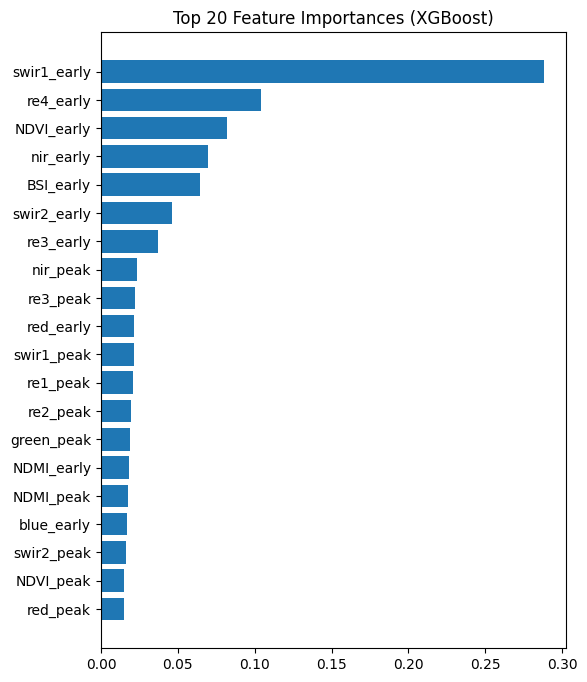

In [72]:
import matplotlib.pyplot as plt
import numpy as np

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 8))
plt.barh(range(20), importances[indices][:20])
plt.yticks(range(20), X.columns[indices][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

In [73]:
import joblib
joblib.dump(xgb_model, '/content/drive/MyDrive/xgb_model_agri.pkl')

['/content/drive/MyDrive/xgb_model_agri.pkl']

In [74]:
import joblib
xgb_model = joblib.load('/content/drive/MyDrive/xgb_model_agri.pkl')

In [76]:
import rasterio
import numpy as np

src = rasterio.open('/content/drive/MyDrive/XGBoost/stack_s2_01.tif')
img = src.read()              # shape: (bands, height, width)
bands, h, w = img.shape
X = img.reshape(bands, h*w).T # (pixels, bands)

In [77]:
print("X shape:", X.shape)                 # (n_pixels, 26) diharapkan
print("Model features:", xgb_model.n_features_in_)

# Prediksi probabilitas kelas positif (misal: sawah → class=1)
y_proba = xgb_model.predict_proba(X)[:, 1]   # shape: (n_pixels,)

X shape: (93500, 26)
Model features: 26


In [78]:
proba_raster = y_proba.reshape(h, w)   # balik ke (height, width)

In [79]:
threshold = 0.5
pred_class = (proba_raster >= threshold).astype(np.uint8)

In [80]:
import rasterio

with rasterio.open('/content/drive/MyDrive/XGBoost/stack_s2_01.tif') as src:
    meta = src.meta.copy()

# Untuk probabilitas (float32)
meta.update({
    "count": 1,
    "dtype": "float32"
})

out_proba = '/content/drive/MyDrive/XGBoost/kp_padi_proba_01.tif'
with rasterio.open(out_proba, 'w', **meta) as dst:
    dst.write(proba_raster.astype('float32'), 1)

# Untuk kelas biner (0/1)
meta.update({
    "count": 1,
    "dtype": "uint8"
})
out_class = '/content/drive/MyDrive/XGBoost/kp_padi_class_01.tif'
with rasterio.open(out_class, 'w', **meta) as dst:
    dst.write(pred_class, 1)

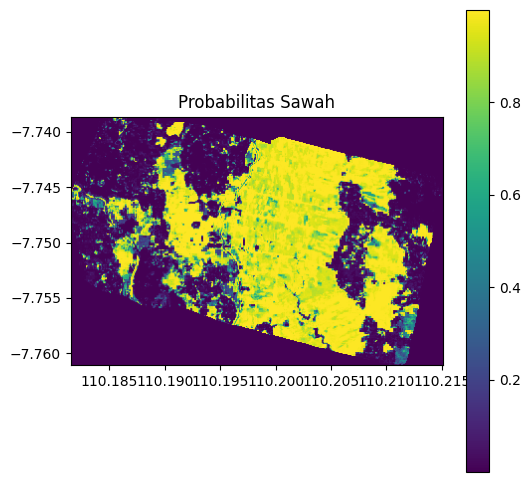

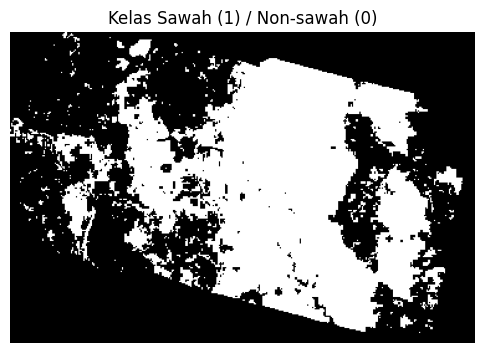

In [84]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Probabilitas
path = '/content/drive/MyDrive/XGBoost/kp_padi_proba_01.tif'

with rasterio.open(path) as src:
    fig, ax = plt.subplots(figsize=(6,6))
    im = show(src, ax=ax, cmap='viridis')  # simpan ke im
    fig.colorbar(im.get_images()[0], ax=ax)  # ambil image dari im
    ax.set_title('Probabilitas Sawah')
    plt.show()

# Kelas biner
with rasterio.open('/content/drive/MyDrive/XGBoost/kp_padi_class_01.tif') as src:
    kelas = src.read(1)

plt.figure(figsize=(6,6))
plt.imshow(kelas, cmap='gray')
plt.title('Kelas Sawah (1) / Non-sawah (0)')
plt.axis('off')
plt.show()